# Forecasting Using Time Series Analysis 


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import datetime
import sys
import seaborn as sns
import statsmodels
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from scipy.stats.mstats import normaltest

from matplotlib.pyplot import acorr
plt.style.use('fivethirtyeight')
%matplotlib inline
import Quandl

## My Former Firm - EnerNOC (NASDAQ: ENOC)

Here, I use time series analysis to forecast the future value of the stock price of the firm I worked for for 8 years, EnerNOC, a global leader in energy management and demand response.


First, I use Quandl, a tool that pulls publically available finical data from around the world, to get the list price of ENOC stock for everyday that it has been traded publically.  I bring this data into python as a pandas data frame.  


In [20]:
#Get stock prices from Quandl
ENOC = Quandl.get("YAHOO/ENOC")
ENOC.to_csv('ENERNOC.csv')
lastENOC = ENOC[-1:]
ENOC = ENOC[:-1]

In [26]:
ENOC.head()

,Open,High,Low,Close,Volume,Adjusted Close,date
Date,,,,,,,
2007-05-18,30.760000,32.480000,30.160000,31.129999,4177000,31.129999,2007-05-18
2007-05-21,31.070000,32.000000,31.000000,32.000000,446800,32.000000,2007-05-21
2007-05-22,32.250000,34.700001,32.000000,33.750000,337600,33.750000,2007-05-22
2007-05-23,33.939999,39.000000,33.509998,35.990002,195300,35.990002,2007-05-23
2007-05-24,36.099998,36.830002,34.099998,35.000000,109800,35.000000,2007-05-24


After renaming the dataframes columns and index, I take the log of the daily the closing value.  This new column is called logENOC.  I take a log because this ensures that level induced volatility does not interfere with the stationarity of my series.  Logging the series prevents overall changes in volume from distorting the behavior of the stock.

In [29]:
ENOC['date']= ENOC.index
ENOC['ENOC']= ENOC.Close
ENOC['logENOC']= np.log(ENOC['ENOC'])
ENOC['diflogENOC'] = ENOC['logENOC'] - ENOC['logENOC'].shift(periods=-1)
ENOC = ENOC.dropna()

Next, I take the difference of the closing values.  This differencing is another way to get my time series to be stationary.  I don’t care about the absolute value of the stock.  That metric is not stationary (it in theory should go up forever!).  Instead I am interested in forecasting the return on the stock.  This is the day to day change in value.  I want to forecast what the change in the stock will be tomorrow, not what the stock will be tomorrow.


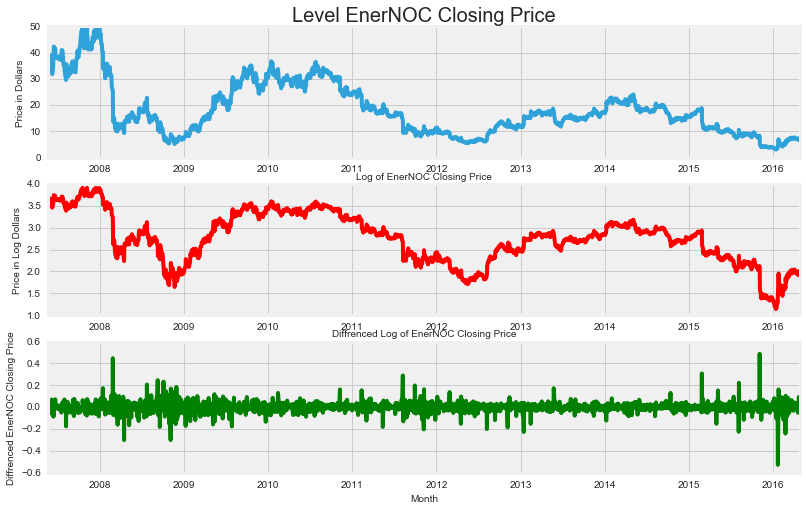

In [115]:
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(3, 1, 1)
plt.plot(ENOC.date, ENOC.ENOC, label = "Log of EnerNOC Closing Price")
plt.title("Level EnerNOC Closing Price", size = 20,)
plt.ylabel("Price in Dollars", size = 10)
#plt.xlabel('Month', size = 10)

plt.subplot(3, 1, 2)
plt.plot(ENOC.date, ENOC.logENOC, label = 'Log of EnerNOC', color = 'r')
plt.title("Log of EnerNOC Closing Price", size = 10,)
plt.ylabel("Price in Log Dollars", size = 10)
#plt.xlabel('Month', size = 10)
#plt.legend(loc='lower right', shadow=True)

plt.subplot(3, 1, 3)
plt.plot(ENOC.date, ENOC.diflogENOC, label = '1st Diffrence of Log of EnerNOC', color = 'g')
plt.title("Diffrenced Log of EnerNOC Closing Price", size = 10,)
plt.ylabel("Diffrenced EnerNOC Closing Price", size = 10)
plt.xlabel('Month', size = 10)

One can see by visual inspection that the level closing price and the log of the level closing price are not mean reverting and are therefore not stationary.  Stationarity is a necessary condition for reliable forecasting.  Visually, the difference of the closing price, the stock returns, do look stationary.


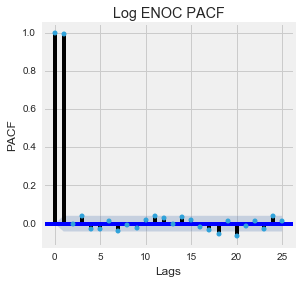

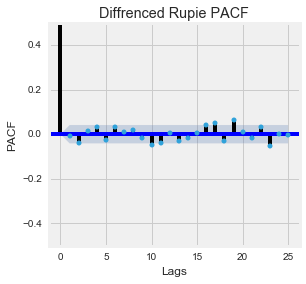

In [37]:
fig, ax = plt.subplots(figsize=(4,4))

plot_pacf(ENOC.logENOC, lags = 25, ax = ax)
ax.set_title('Log ENOC PACF')
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

fig, ax = plt.subplots(figsize=(4,4))

plot_pacf(ENOC.diflogENOC, lags = 25, ax = ax)
ax.set_title('Diffrenced ENOC PACF')
ax.set_ylim(-.5, .5)
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

When one plots the partial autocorrelation function for each type of data, the log shows clear partial autocorrelation, while the differenced value does not.  


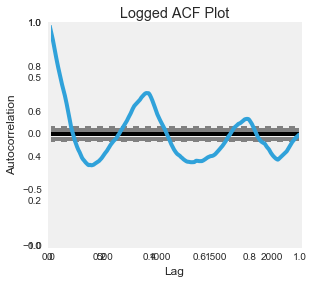

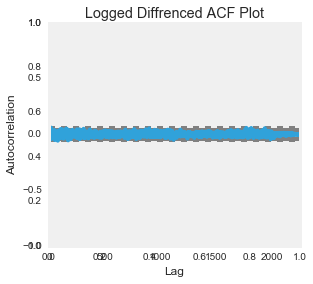

In [38]:
fig, ax = plt.subplots(figsize=(4,4))
ax = autocorrelation_plot(ENOC.logENOC)
ax.set_title('Logged ACF Plot')

fig, ax = plt.subplots(figsize=(4,4))
ax = autocorrelation_plot(ENOC.diflogENOC)
ax.set_title('Logged Diffrenced ACF Plot')

In [42]:
#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
dftest = adfuller(ENOC.diflogENOC, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Results of Dickey-Fuller Test:
Test Statistic                -9.722728e+00
p-value                        9.449236e-17
# Lags Used                    2.200000e+01
Number of Observations Used    2.228000e+03
Critical Value (5%)           -2.862838e+00
Critical Value (1%)           -3.433288e+00
Critical Value (10%)          -2.567461e+00
dtype: float64


The real statistical test of stationarity, the Dickey-Fuller test, yields a very small P-value for the differenced time series proving that it is indeed stationary.


In [43]:
ararray = (ENOC.logENOC.dropna().as_matrix())

p=0
q=0
d=1
pdq=[]
aic=[]

for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(ararray, (p,d,q)).fit()
            x = model.aic
            x1 = (p,d,q)
            
            print (x1, x)
            aic.append(x)
            pdq.append(x1)
        except:
            pass
            
            
keys = pdq
values = aic
d = dict(zip(keys, values))
minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]
print "Best Model is :", (p,d,q)
ARIMIAmod = ARIMA(ararray, (p,d,q)).fit()

((0, 1, 0), -7297.949099436295)
((0, 1, 1), -7296.092445988936)
((0, 1, 2), -7297.662962409944)
((1, 1, 0), -7296.080615486833)
((2, 1, 0), -7297.953999334739)
((2, 1, 1), -7296.166183380994)
Best Model is : (2, 1, 0)


Using Python’s stats model package, and various parameters of an ARIMA (Auto-Regressive-Integrated-Moving-Average) model are thrown at the data.  The model with the lowest Akaike Information Criterion (AIC) a measure of how probable the model’s explanatory power, is selected as the most accurate.  Here the AIRAM model used a p=2, d =1, q= 0. 

In [44]:
pd.DataFrame(zip(pdq, aic)).to_csv("~/desktop/ENERNOCarima.csv")

The model is then used to predict values at each step of the series.  The difference between these values and the actual time series is found and squared.  This is the square error in the model.  

In [46]:
ENOC = ENOC[1:]
ENOC = ENOC.reset_index()
ENOC['predict'] = ARIMIAmod.predict()
ENOC['errors'] = ENOC.diflogENOC - ENOC.predict
ENOC['sqrError'] = ENOC.errors ** 2

The model is then used to forecast a number of steps ahead.  This also produces a 95% confidence interval for this prediction.  


In [91]:
numofsteps = 1
stepahead = ARIMIAmod.forecast(numofsteps)[0]
ferrors = ARIMIAmod.forecast(numofsteps)[2]
ferrors
print '%s Steps Ahead Forecast Value is:' % numofsteps, np.exp(stepahead)
print '%s Steps Ahead 95 percent CI is:' % numofsteps, np.exp(ferrors[0])
print 'April 26th 2016 Close (most recent): %s ' % lastENOC.Close 

1 Steps Ahead Forecast Value is: [ 7.0602713]
1 Steps Ahead 95 percent CI is: [ 6.42991601  7.75242333]
April 26th 2016 Close (most recent): 2249    7.04
Name: Close, dtype: float64 


This prediction at first seems reasonable.  However, on closer inspection the squared residuals show autocorrelation!  


# Autocorrelation Found in the Squares of the Residuals!

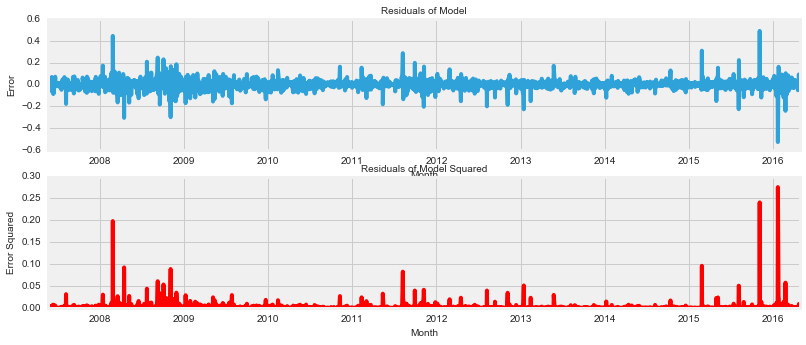

In [48]:
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(3, 1, 1)
plt.plot(ENOC.Date, ENOC.errors, label = "Residual")
plt.title("Residuals of Model", size = 10,)
plt.ylabel("Error", size = 10)
plt.xlabel('Month', size = 10)

plt.subplot(3, 1, 2)
plt.plot(ENOC.Date, ENOC.sqrError, label = 'Residual Squared', color = 'r')
plt.title("Residuals of Model Squared", size = 10,)
plt.ylabel("Error Squared", size = 10)
plt.xlabel('Month', size = 10)
#plt.legend(loc='lower right', shadow=True)

(0, 25)

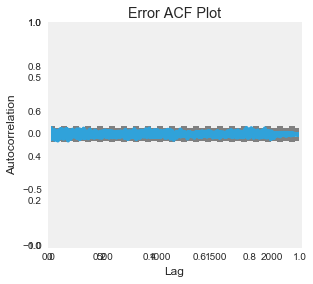

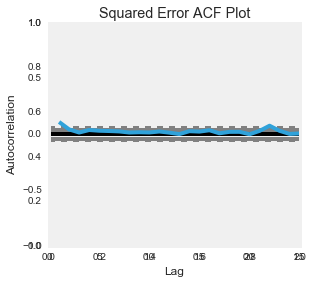

In [49]:
fig, ax = plt.subplots(figsize=(4,4))
ax = autocorrelation_plot(ENOC.errors)
ax.set_title('Error ACF Plot')
#ax.set_xlim(0,25)

fig, ax = plt.subplots(figsize=(4,4))
ax = autocorrelation_plot(ENOC.sqrError)
ax.set_title('Squared Error ACF Plot')
ax.set_xlim(0,25)

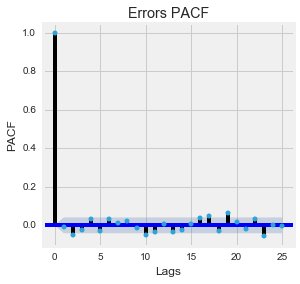

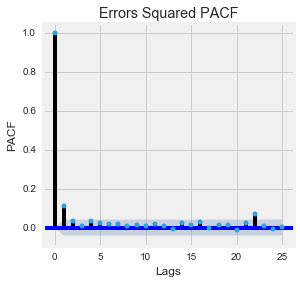

In [50]:
fig, ax = plt.subplots(figsize=(4,4))

plot_pacf(ENOC.errors, lags = 25, ax = ax)
ax.set_title('Errors PACF')
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

fig, ax = plt.subplots(figsize=(4,4))

plot_pacf(ENOC.sqrError, lags = 25, ax = ax)
ax.set_title('Errors Squared PACF')
#ax.set_ylim(-.5, .5)
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

Time to fit an ARCH and GARCH model to account for this conditional heteroscedasticity 

In [57]:
qrange = 10

loglike = []
aic = []
for i in range(qrange+1):
    archmodel = arch_model(ENOC.logENOC, q =i).fit()
    temploglike = archmodel.loglikelihood
    tempaic = archmodel.aic
    loglike.append((temploglike, i))
    aic.append((tempaic))

bestarchmod = arch_model(ENOC.logENOC, q = max(loglike)[1]).fit()
bestarchmod.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1570.8641131
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1567.69350839
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1553.75619317
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1508.16384491
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1464.43866886
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1410.31627903
Iteration:      7,   Func. Count:     49,   Neg. LLF: 1406.68676233
Iteration:      8,   Func. Count:     55,   Neg. LLF: 1313.14360511
Iteration:      9,   Func. Count:     61,   Neg. LLF: 1235.60125388
Iteration:     10,   Func. Count:     66,   Neg. LLF: 767.190477008
Iteration:     11,   Func. Count:     81,   Neg. LLF: 3512.66940983
Iteration:     12,   Func. Count:     95,   Neg. LLF: 715.736383094
Iteration:     13,   Func. Count:    101,   Neg. LLF: 707.215917738
Iteration:     14,   Func. Count:    107,   Neg. LLF: 697.735208284
Iteration:     15,   Func. Count:    113,   Neg. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                logENOC   R-squared:                      -0.012
Mean Model:             Constant Mean   Adj. R-squared:                 -0.012
Vol Model:                      GARCH   Log-Likelihood:               -552.108
Distribution:                  Normal   AIC:                           1120.22
Method:            Maximum Likelihood   BIC:                           1165.96
                                        No. Observations:                 2250
Date:                Fri, Apr 29 2016   Df Residuals:                     2242
Time:                        19:37:45   Df Model:                            8
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             2.8159  2.212e-05  1.273e+05      0.000       [  2.816,  2.816]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      3.8620e-04  1.590e-08  2.429e+04      0.000   [3.862e-04,3.862e-04]
alpha[1]       0.8661  2.156e-03    401.734      0.000       [  0.862,  0.870]
beta[1]        0.1027  1.371e-02      7.491  6.826e-14     [7.583e-02,  0.130]
beta[2]        0.0000  4.151e-03      0.000      1.000  [-8.135e-03,8.135e-03]
beta[3]        0.0000  1.523e-02      0.000      1.000  [-2.985e-02,2.985e-02]
beta[4]        0.0000  1.165e-02      0.000      1.000  [-2.282e-02,2.282e-02]
beta[5]        0.0312  3.890e-03      8.027  1.003e-15   [2.360e-02,3.884e-02]
==============================================================================

Covariance estimator: robust
"""

In [59]:
forpaper = pd.DataFrame(loglike, columns = ['Log Likelyhood', 'q'])
forpaper['AIC'] = aic
forpaper.to_csv("~/desktop/ENOCARCH.csv")

In [61]:
garch = arch_model(ENOC.logENOC, q = 2, vol = 'garch').fit()
garch.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 977.986504321
Iteration:      2,   Func. Count:     20,   Neg. LLF: 965.962507654
Iteration:      3,   Func. Count:     28,   Neg. LLF: 927.741066843
Iteration:      4,   Func. Count:     36,   Neg. LLF: 785.211394123
Iteration:      5,   Func. Count:     44,   Neg. LLF: 761.141655104
Iteration:      6,   Func. Count:     51,   Neg. LLF: 621.675245992
Iteration:      7,   Func. Count:     58,   Neg. LLF: 610.525954878
Iteration:      8,   Func. Count:     66,   Neg. LLF: 605.626644526
Iteration:      9,   Func. Count:     73,   Neg. LLF: 581.392052999
Iteration:     10,   Func. Count:     81,   Neg. LLF: 572.266121878
Iteration:     11,   Func. Count:     93,   Neg. LLF: 572.249373145
Iteration:     12,   Func. Count:    101,   Neg. LLF: 571.205860944
Iteration:     13,   Func. Count:    110,   Neg. LLF: 570.053816326
Iteration:     14,   Func. Count:    118,   Neg. LLF: 566.347268909
Iteration:     15,   Func. Count:    126,   Neg.

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                logENOC   R-squared:                      -0.012
Mean Model:             Constant Mean   Adj. R-squared:                 -0.012
Vol Model:                      GARCH   Log-Likelihood:               -554.194
Distribution:                  Normal   AIC:                           1118.39
Method:            Maximum Likelihood   BIC:                           1146.98
                                        No. Observations:                 2250
Date:                Fri, Apr 29 2016   Df Residuals:                     2245
Time:                        19:44:38   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             2.8164  2.602e-05  1.082e+05      0.000       [  2.816,  2.816]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      4.5352e-04  2.454e-08  1.848e+04      0.000   [4.535e-04,4.536e-04]
alpha[1]       0.8570  2.519e-03    340.240      0.000       [  0.852,  0.862]
beta[1]        0.1430  1.591e-02      8.993  2.405e-19       [  0.112,  0.174]
beta[2]        0.0000  7.558e-03      0.000      1.000  [-1.481e-02,1.481e-02]
==============================================================================

Covariance estimator: robust
"""

In [92]:
print 'ARCH(1)'
print 'AIC = ', bestarchmod.aic
print 'Log Likelihood = ', bestarchmod.loglikelihood
print '---'
print 'GARCH (1,1)'
print 'AIC = ', garch.aic
print 'Log Likelihood = ', garch.loglikelihood

ARCH(1)
AIC =  1120.21506727
Log Likelihood =  -552.107533637
---
GARCH (1,1)
AIC =  1118.38876429
Log Likelihood =  -554.194382145


The ARCH model outperforms the GARCH model

In [93]:
bestarchmod = arch_model(ENOC.logENOC, q = 1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 963.169924342
Iteration:      2,   Func. Count:     18,   Neg. LLF: 951.077540286
Iteration:      3,   Func. Count:     25,   Neg. LLF: 909.035073072
Iteration:      4,   Func. Count:     32,   Neg. LLF: 800.676791448
Iteration:      5,   Func. Count:     38,   Neg. LLF: 775.31778307
Iteration:      6,   Func. Count:     45,   Neg. LLF: 646.832809962
Iteration:      7,   Func. Count:     51,   Neg. LLF: 608.207383007
Iteration:      8,   Func. Count:     60,   Neg. LLF: 578.775874025
Iteration:      9,   Func. Count:     69,   Neg. LLF: 565.95515732
Iteration:     10,   Func. Count:     75,   Neg. LLF: 559.747247208
Iteration:     11,   Func. Count:     81,   Neg. LLF: 556.925614258
Iteration:     12,   Func. Count:     87,   Neg. LLF: 555.769239155
Iteration:     13,   Func. Count:     93,   Neg. LLF: 554.963050924
Iteration:     14,   Func. Count:     99,   Neg. LLF: 554.77073579
Iteration:     15,   Func. Count:    105,   Neg. LL

In [95]:
bestarchmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                logENOC   R-squared:                      -0.012
Mean Model:             Constant Mean   Adj. R-squared:                 -0.012
Vol Model:                      GARCH   Log-Likelihood:               -554.194
Distribution:                  Normal   AIC:                           1116.39
Method:            Maximum Likelihood   BIC:                           1139.26
                                        No. Observations:                 2250
Date:                Fri, Apr 29 2016   Df Residuals:                     2246
Time:                        21:21:20   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             2.8164  2.826e-05  9.965e+04      0.000       [  2.816,  2.816]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      4.5355e-04  2.203e-08  2.059e+04      0.000   [4.535e-04,4.536e-04]
alpha[1]       0.8570  2.079e-03    412.233      0.000       [  0.853,  0.861]
beta[1]        0.1430  2.177e-03     65.689      0.000       [  0.139,  0.147]
==============================================================================

Covariance estimator: robust
"""

In [96]:
bestarchmod.conf_int().iloc[2,0]

0.85290435036147227

In [97]:
onestepforecast = np.exp(bestarchmod.forecast().iloc[1,0])
onestepforecastCI = np.exp(bestarchmod.conf_int().iloc[2,0])

In [116]:
print '%s Steps Ahead Forecast Value is: %s Dollars' % (numofsteps, onestepforecast)
print '%s Steps Ahead 95 Percent CI is %s and %s' % (numofsteps, onestepforecast+onestepforecastCI, onestepforecast-onestepforecastCI)
print 'Most Recent EnerNOC Close: %s' % (lastENOC.Close)

1 Steps Ahead Forecast Value is: 16.7159626052 Dollars
1 Steps Ahead 95 Percent CI is 19.0624144886 and 14.3695107218
Most Recent EnerNOC Close: 2249    7.04
Name: Close, dtype: float64


In [67]:
ENOC['conditional_variances'] = bestarchmod.conditional_volatility  ** 2

# Final Prediction


As expected the ARCH model accounts for the conditional heteroscedasticity.  Therefore, the ARCH model is used to make the prediction.  The resulting model is used to predict values and again compare them against the historically accurate time series.  The difference between the time series and the predictions are the errors.  Comparing the performance of the model against the actual performance over time yields a relatively accurate picture.



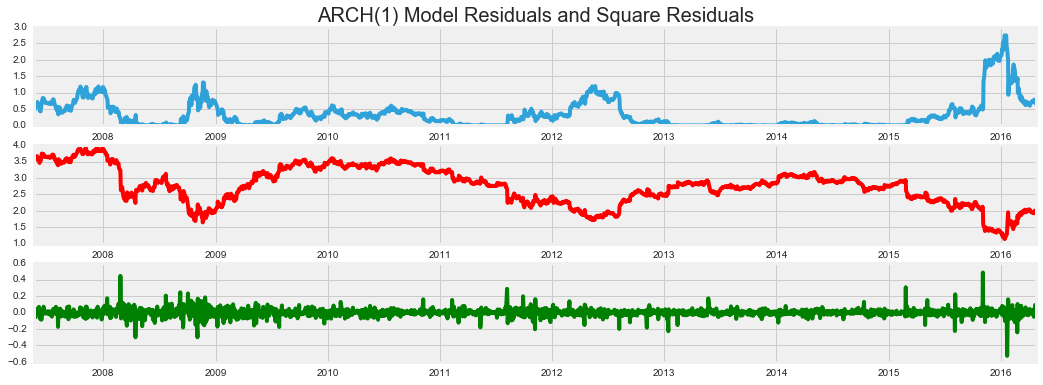

In [107]:
fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(3, 1, 1)
plt.title('ARCH(1) Model Residuals and Square Residuals', size = 20)
plt.plot(ENOC.date, ENOC['conditional_variances'])
plt.subplot(3, 1, 2)
plt.plot(ENOC.date, ENOC.logENOC, c= 'r')
plt.subplot(3, 1, 3)

plt.plot(ENOC.date, ENOC.diflogENOC, c= 'g')

In [72]:
ENOC['archresiduals'] = bestarchmod.resid
ENOC['bestarchmodel'] = ENOC.logENOC + ENOC.archresiduals
ENOC['bestarchmodelhigh'] = ENOC['bestarchmodel']+bestarchmod.conf_int().iloc[2,0]
ENOC['bestarchmodellow'] = ENOC['bestarchmodel']-bestarchmod.conf_int().iloc[2,1]

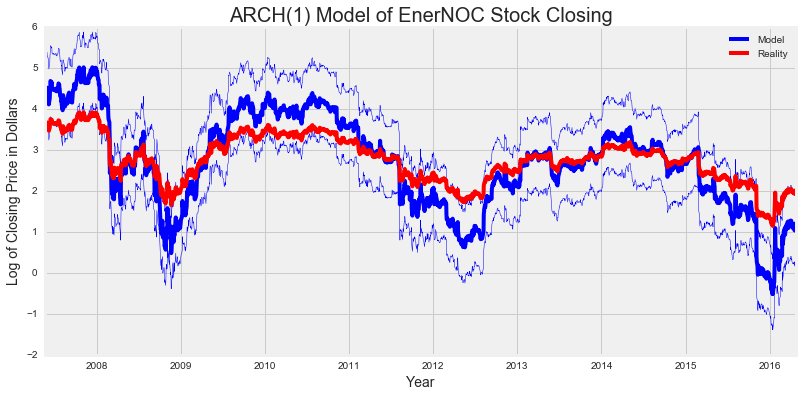

In [108]:
fig, ax = plt.subplots(figsize=(12,20))
plt.subplot(3, 1, 1)
plt.plot(ENOC.date, ENOC['bestarchmodel'], label = 'Model', c = 'b')
plt.plot(ENOC.date, ENOC['bestarchmodelhigh'], linewidth = .5, c = 'b', label = '')
plt.plot(ENOC.date, ENOC['bestarchmodellow'], linewidth = .5, c = 'b', label = '')
plt.plot(ENOC.date, ENOC['logENOC'], label = 'Reality', c = 'r')
plt.legend()
plt.title('ARCH(1) Model of EnerNOC Stock Closing', size = 20)
plt.xlabel('Year', size = 14)
plt.ylabel('Log of Closing Price in Dollars', size = 14)

# plt
# plt.subplot(3, 1, 2)
# plt.plot(rup.Date, rup.logRup, c= 'r')
# plt.subplot(3, 1, 3)
# plt.plot(rup.Date, rup.logdifRup, c= 'g')

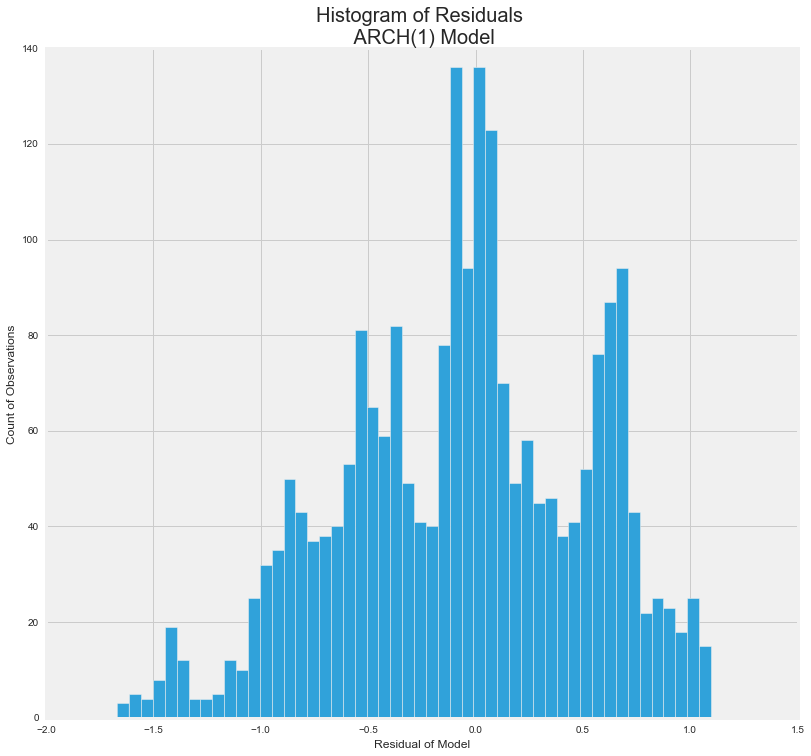

In [111]:
fig, ax = plt.subplots(figsize=(12,12))
ENOC.archresiduals.hist(bins = 50)
plt.title('Histogram of Residuals \n ARCH(1) Model', size = 20)
plt.xlabel('Residual of Model')
plt.ylabel('Count of Observations')

In [110]:
normaltest(np.asarray(ENOC.archresiduals))

NormaltestResult(statistic=55.427791836964538, pvalue=9.2046638004671287e-13)

In [82]:
ENOC['fail'] = ENOC['bestarchmodelhigh'] < ENOC['logENOC']
ENOC['fail'].sum()

208

In [112]:
len(ENOC)

2250

In [114]:
208./2250

0.09244444444444444